# Investigating the Gapminder Systema Globalis Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The name "Systema Globalis" is inspired by [Systema Naturae](https://en.wikipedia.org/wiki/Systema_Naturae); the first systematic compilation of all living things from year 1735, by the Swedish Scientist Carl von Linné. The goal of Systema Globalis is to compile all public statistics; Social, Economic and Environmental; into a comparable total dataset.

### Data
This is the main dataset used in tools on the official Gapminder website. It contains local &amp; global statistics combined from hundreds of sources.

For the purposes of this demonstration, we will be using the glob module for file manipulation, pandas and numpy for working with the data, and matplotlib's basic pyplot suite for visualization.

_This exercise is intended to illustrate the choices an analyst must make at each point of the data analysis process, from the initial data-wrangling to the final presentation of findings. The process shown is not being presented as an optimal route. Rather, the intent is to provide a realistic look at how an analyst might approach an unfamiliar dataset, including illustration of the potential pitfalls they may encounter._ 

In [591]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The Systema Globalis data consists of longitudinal country-level data on over 500 indicators of social, economic, health, environmental, and other comparative measures. The data on each indicator is contained in its own csv file, organized by country (geo) and year of measurement (time). 

### General Properties

Due to the multi-file structure of this dataset, analysis involving more than one indicator requires file operations to parse, read, and merge the data from each target indicator. The glob module simplifies this process, allowing for filename 'globbing' based on wildcard searches of filenames. This provides one method of subsetting the files and extracting only the data we are interested in analyzing. 

For example: 

In [20]:
# Returns only the filenames of 'datapoint' csv files containing literacy data:
datafiles_literacy = glob.glob('*datapoints*literacy*.csv')
print(np.array(datafiles_literacy)[:3], '\n\n')

# Returns only the filenames of 'datapoint' csv files containing energy data:
datafiles_energy = glob.glob('*datapoints*energy*.csv')
print(np.array(datafiles_energy)[:3])

['ddf--datapoints--literacy_rate_adult_female_percent_of_females_ages_15_above--by--geo--time.csv'
 'ddf--datapoints--literacy_rate_adult_male_percent_of_males_ages_15_and_above--by--geo--time.csv'
 'ddf--datapoints--literacy_rate_adult_total_percent_of_people_ages_15_and_above--by--geo--time.csv'] 


['ddf--datapoints--energy_from_solid_biofuels_percent--by--geo--time.csv'
 'ddf--datapoints--energy_production_per_person--by--geo--time.csv'
 'ddf--datapoints--energy_production_total--by--geo--time.csv']


In the alternative, we can simply read all of the data into Python, and hold off on trimming it down or subsetting it until after its all been processed.  This will be more computationally intensive than importing only a target subset, and would be impractical (or even impossible) with very large datasets, but there is a certain appeal to compiling all of the relevant data in a single place and while complex, this dataset is not so large to make this too unweildly, so an analyst may opt for this route even though it may bring with it some complications.  

In [21]:
datafiles_all = glob.glob('*datapoints*.csv')

The gapminder data is particularly well suited to exploratory data analysis because it is largely 'pre-cleaned'. Each table shares a uniform format, making it very easy to read in and merge the data from multiple indicators. 

While data 'wrangling' can be a complex, time-consuming process, especially when dealing with messy data or data from multiple sources, it can be accomplished here with relative ease.

In [22]:
# create empty dictionary into which we will read all of our data files
ref = {}

# loop through filenames, extracting indicator name from filename, and values from each file itself
for filename in datafiles_all:
    key = filename.partition('datapoints--')[2].partition('--')[0]
    data = pd.read_csv(filename)
    # index each table by country and cast longitudinal progression to columns 
    data = data.pivot(index='geo', columns='time')
    # incorporate second-level index (indicator name), necessary when merging multiple indicators 
    data = data.stack(level=0)
    data.index.set_names('indicator', level=1, inplace=True)
    # dictionary entry: key = indicator name, value = reformatted dataframe
    ref[key] = data

We now have a reference dictionary containing the entire gapminder dataset. As mentioned eariler, this "everything in one place" approach is sub-optimal for a number of reasons, one of which will become apparent soon. 

We will finish the process by concatenating all of these individual tables into a single master dataframe. Again, we ensured that this would go smoothly by reindexing and reshaping in the previous step.

In [23]:
master = pd.concat(ref.values())
master = master.sort_index()
# let's take a look at some attributes of our master dataframe
print("column names are:", master.columns)
print("index names are:", master.index.names)
print("shape is:", master.shape)
print("total missing values:", master.isna().sum().sum())
print("non-missing values:", master.count().sum())

column names are: Int64Index([1086, 1100, 1279, 1290, 1300, 1309, 1348, 1349, 1351, 1352,
            ...
            2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
           dtype='int64', name='time', length=409)
index names are: ['geo', 'indicator']
shape is: (87888, 409)
total missing values: 33046225
non-missing values: 2899967


__Whoa__, this is a bit of a mess. There are datapoints going back all the way to the 11th century, and there are even points out into the future! How is that possible? 

Furthermore, our table contains over 33 million missing values, and fewer than 3 million actual values. In other words, the majority of our dataframe is pretty much useless.

A closer look at our indicators shows that while most of the indicators contain observed values, some are projections. This explains the values for future years. We could fix this by not loading in those particular indicators, or by filtering our data to a specific timeframe. 

How about those missing values though?  Let's take a closer look:

In [6]:
print(master.count().describe())

count      409.000000
mean      7090.383863
std      11610.421421
min          1.000000
25%         70.000000
50%       3874.000000
75%       4998.000000
max      59140.000000
dtype: float64


Ok, that explains a lot. If there were no values missing in our table, we would expect to see almost 88,000 observations for each year. Here we see that 75% of years contain fewer than 5000 observations, that there is at least one year that contains only 1 single value, and that even the year for which we have the most information still contains almost 30,000 missing values.   

(array([  4.,   6.,   8.,   4.,  10.,   7.,   9.,  11.,  25., 325.]),
 array([28860. , 34773.9, 40687.8, 46601.7, 52515.6, 58429.5, 64343.4,
        70257.3, 76171.2, 82085.1, 87999. ]),
 <a list of 10 Patch objects>)

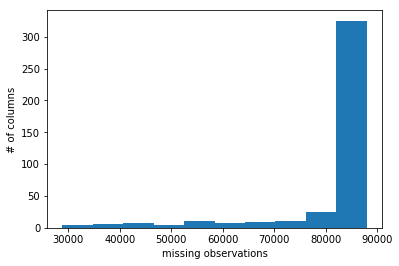

In [7]:
plt.xlabel('missing observations')
plt.ylabel('# of columns')
plt.hist(88000 - master.count())

### Data Cleaning
In our attempt to put everything in one place, we created a HUGE but mostly empty dataset. The most obvious culprits based on our cursory look are the very early years that contain very few observations, and the future (projection) years which also contain relatively few observations. 

There are some less obvious complications though:
1) Countries whose names change
2) Countries for which very little data has been collected
3) Indicators which only contain data for a limited timeframe

These can each be addressed, whether by 
1) limiting the scope of analysis to only certain countries, 
2) certain indicators, or 
3) certain time-periods 

Each of these solutions moves us away from the 'everything in one place' approach we were initially going for, but would also prevent the replication of tons of empty values.

What follows are two examples of how the assembly process used earlier could have been modified to reduce the size of the dataframe output based on user-determined filtering criteria. 

In [8]:
# Filtering by time and indicator 
d1 = {}

for filename in datafiles_all:
    # read in only filenames containing certain keywords
    if re.search('income|cancer.deaths.*100000', filename):
        key = filename.partition('datapoints--')[2].partition('--')[0]
        data = pd.read_csv(filename)
        # 'pre-cleaning' step to exclude data from earlier than 1950, and exclude projections
        data = data[data.time >= 1950]
        data = data[data.time <= 2018] 
        data = data.pivot(index='geo', columns='time')
        data = data.stack(level=0)
        data.index.set_names('indicator', level=1, inplace=True)
        d1[key] = data

In [9]:
# Filtering by time and country
d2 = {}

for filename in datafiles_all:
    key = filename.partition('datapoints--')[2].partition('--')[0]
    data = pd.read_csv(filename)
    data = data[data.time >= 1950]
    data = data[data.time <= 2018] 
    # from each indicator, retain only the data for the following five countries
    data = data.loc[(data.geo == 'usa') | (data.geo == 'ger') | (data.geo == 'chi') |
                    (data.geo == 'jap') | (data.geo == 'aus')]
    data = data.pivot(index='geo', columns='time')
    data = data.stack(level=0)
    data.index.set_names('indicator', level=1, inplace=True)
    d2[key] = data

In [10]:
t1 = pd.concat(d1.values())
t1 = t1.sort_index()
print("column bounds are:", (t1.columns.min(), t1.columns.max()))
print("shape of t1 is:", t1.shape)
print("total missing values in t1:", t1.isna().sum().sum())
print("non-missing values in t1:", t1.count().sum(), '\n')

t2 = pd.concat(d2.values())
t2 = t2.sort_index()
print("shape of t2 is:", t2.shape)
print("total missing values in t2:", t2.isna().sum().sum())
print("non-missing values in t2:", t2.count().sum())

column bounds are: (1950, 2018)
shape of t1 is: (4547, 69)
total missing values in t1: 199787
non-missing values in t1: 113956 

shape of t2 is: (1004, 69)
total missing values in t2: 41420
non-missing values in t2: 27856


As you can see, by limiting the data we read in during our initial sweep of the datafile directory, we reduced the size of our working datasets, and also dramatically cut down on the number of missing values we would now have to deal with during analysis. 

Of course, we could accomplish the same thing by simply subsetting our comprehensive (but bloated) 'master' dataset since we've already assembled it. 

In [11]:
# Filtering by time and indicator

master_t1 = master.loc[:, 1950:2018].filter(regex='income|cancer.deaths.*100000', axis=0)
print(master_t1.shape == t1.shape)

True


In [12]:
# Filtering by time and country

master_t2 = master.loc[['usa', 'ger', 'chi', 'jap', 'aus'], 1950:2018].dropna(how='all', axis=0)
print(master_t2.shape == t2.shape)

True


In this case, neither approach is purely 'better' or 'worse', but as noted before, the performance burden of building an initial comprehensive dataset could be dramatic with larger multi-dimensional data, so pre-processing is generally preferred. 


For the purpose of this exercise we will create a third subset which contains only data for the United States going back no earlier than the 20th century. This will be our most restrictive set thus far.

In [13]:
usa = master.loc['usa', 1900:2018].dropna(how='all', axis=0)
usa.index

Index(['adults_with_hiv_percent_age_15_49', 'age_at_1st_marriage_women',
       'aged_15_24_employment_rate_percent',
       'aged_15_24_unemployment_rate_percent',
       'aged_15_64_labour_force_participation_rate_percent',
       'aged_15plus_employment_rate_percent',
       'aged_15plus_labour_force_participation_rate_percent',
       'aged_15plus_unemployment_rate_percent',
       'aged_25_54_labour_force_participation_rate_percent',
       'aged_25_54_unemployment_rate_percent',
       ...
       'urban_population', 'urban_population_growth_annual_percent',
       'urban_population_percent_of_total',
       'water_and_sanitation_aid_given_percent_of_aid',
       'water_withdrawal_cu_meters_per_person', 'wood_removal_cubic_meters',
       'working_hours_per_week', 'year_categorization_1820_2010',
       'year_categorization_1950', 'yearly_co2_emissions_1000_tonnes'],
      dtype='object', name='indicator', length=504)

As we can see, even after restricting our data to that from a single country, we're still left with 504 different observations for each year. While it is nice to be able to create these subsets of data with relative ease, it seems that their practical value may end up being somewhat limited for the purposes of exploratory data analysis. 

The derivation of any meaningful insights will probably require looking at only one or two indicators at a time. Aha! Speaking of insights, now we should have a better idea why the folks who maintain the gapfinder data decided to store each indicator in its own separate table. Surely they understood that the data would be much easier to navigate that way! 

<a id='eda'></a>
## Exploratory Data Analysis

Now that we've experimented with trimming and cleaning the data, we're ready to move on to exploration. We'll compute statistics and create visualizations with the goal of identifying trends within a single variable over time, and then follow that up by looking for relationships between variables. Some exploration may be visual, and some may be computational.

For now, we are going to take a look at a single indicator: "income per person, gdp per capita ppp inflation adjusted". This is a general indicator which can be used as a rough guide to estimating how much the 'average' citizen of a country earns as income in a given year. This value is already adjusted for inflation. 

First we can isolate this indicator and create a new dataframe consisting of only its values worldwide since 1950. We will filter this from t1, one of our smaller subset tables which contains all indicators including the word 'income' and is already limited to data between 1950 and 2018.  

(204, 69)


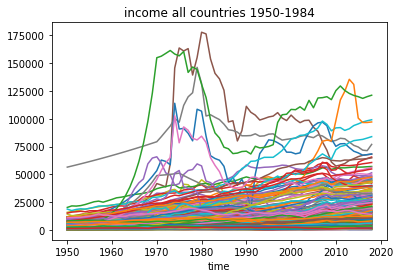

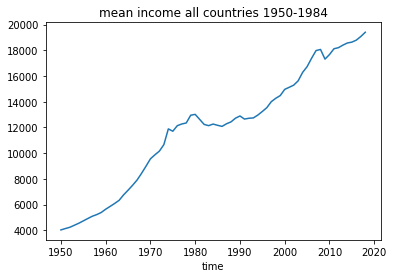

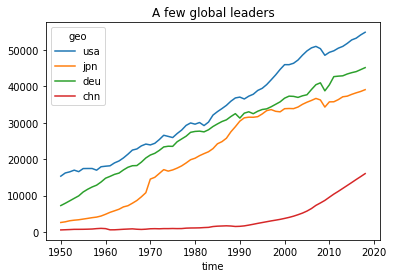

In [582]:
incomepp = t1.filter(like='income_per_person_gdppercapita_ppp_inflation_adjusted', axis=0)
# Dropping the indicator index (since we're only looking at a single indicator right now) may make
# our data easier to manipulate
incomepp.index = incomepp.index.droplevel(1)
print(incomepp.shape)
incomepp.T.plot(legend=False, title='income all countries 1950-1984')
plt.show()
incomepp.mean().plot(legend=False, title='mean income all countries 1950-1984')
plt.show()
incomepp.loc[['usa', 'jpn', 'deu', 'chn']].T.plot(title = 'A few global leaders')
plt.show()

We can see, just by looking at the graphical representation of this income data, that there has been a clear upward trend in individual wealth over the past 68 years. We can see that some of the most well-off countries took a major hit during the 1980s, and that on average, the global growth stopped during this time. We can't tell which countries those are just by looking at these graphs though. We'll return to this question later.

Generally speaking, we can't tell much about individual countries by looking at graphs of aggregate calculations or all of our data at once. We are able to focus a bit more on individual countries by selecting only a few as we did in the third plot, but to dig a little deeper and explore a bit more we'll probably want to do some calculations now.

### 1) Which country's citizens have seen the largest increase in individual wealth (measured as income per person w/ ppp and inflation adjustments) over the past 68 years?

This is a relatively easy question to answer. In order to measure the increase (or decrease) in income, we simply look at the difference between the starting and ending points. This will give us a single value for each country, and we can then sort those values to determine the biggest 'winners' and 'losers'. 

In [622]:
raw_growth = (incomepp.iloc[:,-1]-incomepp.iloc[:,0])
percent_growth = (raw_growth/incomepp.iloc[:,0]*100).dropna().sort_values(ascending=False)
print(percent_growth.head(), '\n\n', percent_growth.tail(), '\n\n')

print("United States percent growth from 1950-2018:", round(percent_growth['usa'],2))


geo
qat    7450.41
are    5548.26
kor    4536.44
gnq    4180.13
chn    2888.43
dtype: object 

 geo
hti   -25.0328
som   -36.9107
caf   -43.1518
lbr   -46.5287
cod   -52.1046
dtype: object 


United States percent growth from 1950-2018: 258.41


Wow, this is shocking! First of all, look at those gains in the top five countries. Remember, these are percentages, so that 4536 for Korea means that income has increased 45 times over. On the other hand, the citizens of some countries have actually experienced a DECREASE in income over the past 68 years. Somalia, the Central African Republic, Haiti, Liberia, and the Democratic Republic of the Congo experienced the worst negative gain out of all of the tracked countries, with income in the Congo decreasing by over 50%. 

It would seem that individuals in Quatar, the UAE, Korea, China, and Equatorial Guinea have made incredible gains over the past 68 years. This would be an excellent jumping-off point for further investigation into these individual countries. Why did the top 5 do so well? Why did the bottom 5 do so poorly? These questions are beyond the scope of this exercise, but you get the idea.

### 2) Which countries 

In [171]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


geo  indicator                                            
abw  income_per_person_gdppercapita_ppp_inflation_adjusted    35324
afg  income_per_person_gdppercapita_ppp_inflation_adjusted      827
ago  income_per_person_gdppercapita_ppp_inflation_adjusted     2666
alb  income_per_person_gdppercapita_ppp_inflation_adjusted    10506
and  income_per_person_gdppercapita_ppp_inflation_adjusted    44510
are  income_per_person_gdppercapita_ppp_inflation_adjusted    67023
arg  income_per_person_gdppercapita_ppp_inflation_adjusted    10625
arm  income_per_person_gdppercapita_ppp_inflation_adjusted     6798
atg  income_per_person_gdppercapita_ppp_inflation_adjusted    17561
aus  income_per_person_gdppercapita_ppp_inflation_adjusted    33716
aut  income_per_person_gdppercapita_ppp_inflation_adjusted    37706
aze  income_per_person_gdppercapita_ppp_inflation_adjusted    12914
bdi  income_per_person_gdppercapita_ppp_inflation_adjusted      178
bel  income_per_person_gdppercapita_ppp_inflation_adjuste

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [16]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0